# Time delay-cosmography with uncertain PSF

This notebook requires standard python libraries and the publicly available packages on github:

- lenstronomy (https://github.com/sibirrer/lenstronomy)
- fastell4py (https://github.com/sibirrer/fastell4py), based on the original fastell fortran code (by Barkana)

The packages are based on Birrer, Amara & Refregier 2015 and Birrer et al. 2018
Installation for each package can be found on the github page.
WARNING: a proper installation of fastell4py   needs a fortran compiler.
This notebook has been tested with lenstronomy 0.3.1.

For further information, please get in touch with the author of this notebook, Simon Birrer: sibirrer@gmail.com

In [1]:
# import of standard python libraries
import numpy as np
import os
import time
import corner
import astropy.io.fits as pyfits

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.PointSource.point_source import PointSource
from lenstronomy.ImSim.image_model import ImageModel
import lenstronomy.Util.param_util as param_util
import lenstronomy.Util.simulation_util as sim_util
import lenstronomy.Util.image_util as image_util
from lenstronomy.Data.imaging_data import Data
from lenstronomy.Data.psf import PSF

## simulation choices

/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log10


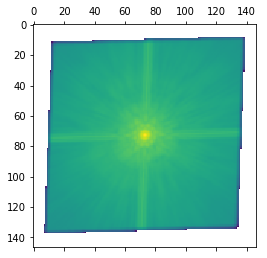

/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log10


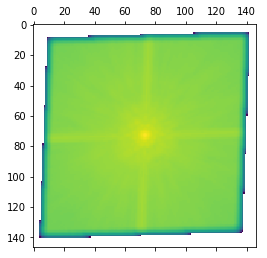

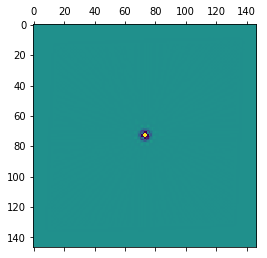

In [2]:

# define lens configuration and cosmology (not for lens modelling)
z_lens = 0.5
z_source = 1.5
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Ob0=0.)


# import PSF file
path = os.getcwd()
dirpath, _ = os.path.split(path)
module_path, _ = os.path.split(dirpath)
psf_filename = os.path.join(module_path, 'Data/PSF_TinyTim/psf_example.fits')
kernel = pyfits.getdata(psf_filename)

# blurr the PSF, this will be our starting point estimate
import scipy.ndimage as ndimage
kernel_blurred = ndimage.filters.gaussian_filter(kernel, 0.5, mode='nearest', truncate=5)

plt.matshow(np.log10(kernel))
plt.show()

plt.matshow(np.log10(kernel_blurred))
plt.show()

plt.matshow(kernel - kernel_blurred, vmin=-0.001, vmax=0.001)
plt.show()

    
# data specifics
sigma_bkg = .05  #  background noise per pixel (Gaussian)
exp_time = 100.  #  exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)
numPix = 100  #  cutout pixel size
deltaPix = 0.05  #  pixel size in arcsec (area per pixel = deltaPix**2)
psf_type = 'PIXEL'  # 'gaussian', 'pixel', 'NONE'
kernel_size = 91

# initial input simulation

# generate the coordinate grid and image properties
kwargs_data = sim_util.data_configure_simple(numPix, deltaPix, exp_time, sigma_bkg)
data_class = Data(kwargs_data)
# generate the psf variables
kwargs_psf_true = sim_util.psf_configure_simple(psf_type=psf_type, kernelsize=kernel_size, deltaPix=deltaPix, kernel=kernel)
kwargs_psf = sim_util.psf_configure_simple(psf_type=psf_type, kernelsize=kernel_size, deltaPix=deltaPix, kernel=kernel_blurred)
psf_class_true = PSF(kwargs_psf_true)
psf_class = PSF(kwargs_psf)


/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:77: RuntimeWarning: invalid value encountered in log10


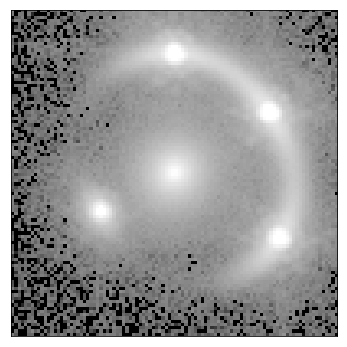

In [6]:
# lensing quantities
kwargs_shear = {'e1': 0.0, 'e2': -0.05}  # shear values to the source plane
kwargs_spemd = {'theta_E': 1.66, 'gamma': 1.95, 'center_x': 0.0, 'center_y': 0, 'e1': 0.1, 'e2': 0.1}  # parameters of the deflector lens model

# the lens model is a supperposition of an elliptical lens model with external shear
lens_model_list = ['SPEMD', 'SHEAR']
kwargs_lens = [kwargs_spemd, kwargs_shear]
lens_model_class = LensModel(lens_model_list=lens_model_list)

# choice of source type
source_type = 'SERSIC'  # 'SERSIC' or 'SHAPELETS'

source_x = 0.2
source_y = 0.1


# Sersic parameters in the initial simulation
phi_G, q = 0.5, 0.8
e1, e2 = param_util.phi_q2_ellipticity(phi_G, q)
kwargs_sersic_source = {'amp': 4000, 'R_sersic': 0.1, 'n_sersic': 1, 'e1': e1, 'e2': e2, 'center_x': source_x, 'center_y': source_y}
#kwargs_else = {'sourcePos_x': source_x, 'sourcePos_y': source_y, 'quasar_amp': 400., 'gamma1_foreground': 0.0, 'gamma2_foreground':-0.0}
source_model_list = ['SERSIC_ELLIPSE']
kwargs_source = [kwargs_sersic_source]
source_model_class = LightModel(light_model_list=source_model_list)


# lens light model
phi_G, q = 0.9, 0.9
e1, e2 = param_util.phi_q2_ellipticity(phi_G, q)
kwargs_sersic_lens = {'amp': 8000, 'R_sersic': 0.2, 'n_sersic': 2., 'e1': e1, 'e2': e2, 'center_x': 0.0, 'center_y': 0}
lens_light_model_list = ['SERSIC_ELLIPSE']
kwargs_lens_light = [kwargs_sersic_lens]
lens_light_model_class = LightModel(light_model_list=lens_light_model_list)

lensEquationSolver = LensEquationSolver(lens_model_class)
x_image, y_image = lensEquationSolver.findBrightImage(source_x, source_y, kwargs_lens, numImages=4,
                                                      min_distance=deltaPix, search_window=numPix * deltaPix)
mag = lens_model_class.magnification(x_image, y_image, kwargs=kwargs_lens)
kwargs_ps = [{'ra_image': x_image, 'dec_image': y_image,
                           'point_amp': np.abs(mag)*1000}]  # quasar point source position in the source plane and intrinsic brightness
point_source_list = ['LENSED_POSITION']
point_source_class = PointSource(point_source_type_list=point_source_list, fixed_magnification_list=[False])

kwargs_numerics = {'subgrid_res': 1, 'psf_subgrid': False,
                  'point_source_subgrid': 3}

imageModel = ImageModel(data_class, psf_class_true, lens_model_class, source_model_class,
                                lens_light_model_class,
                                point_source_class, kwargs_numerics=kwargs_numerics)

# generate image
image_sim = imageModel.image(kwargs_lens, kwargs_source, kwargs_lens_light, kwargs_ps)
poisson = image_util.add_poisson(image_sim, exp_time=exp_time)
bkg = image_util.add_background(image_sim, sigma_bkd=sigma_bkg)
image_sim = image_sim + bkg + poisson
data_class.update_data(image_sim)
kwargs_data['image_data'] = image_sim


kwargs_model = {'lens_model_list': lens_model_list, 
                 'lens_light_model_list': lens_light_model_list,
                 'source_light_model_list': source_model_list,
                'point_source_model_list': point_source_list
                 }

# display the initial simulated image
cmap_string = 'gray'
cmap = plt.get_cmap(cmap_string)
cmap.set_bad(color='k', alpha=1.)
cmap.set_under('k')

v_min = -4
v_max = 2

f, axes = plt.subplots(1, 1, figsize=(6, 6), sharex=False, sharey=False)
ax = axes
im = ax.matshow(np.log10(image_sim), origin='lower', vmin=v_min, vmax=v_max, cmap=cmap, extent=[0, 1, 0, 1])
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)
plt.show()

## time delays
time delays are defined in **lenstronomy** as the difference in light travel path relative to a straight line. Negative values correspond to earlier arrival times. The units are in days.

In [7]:
from lenstronomy.Analysis.lens_properties import LensProp
lensProp = LensProp(z_lens, z_source, kwargs_model, cosmo=cosmo)

# time delays, the unit [days] is matched when the lensing angles are in arcsec
t_days = lensProp.time_delays(kwargs_lens, kwargs_ps, kappa_ext=0)
print("the time delays for the images at position ", kwargs_ps[0]['ra_image'], kwargs_ps[0]['dec_image'], "are: ", t_days)

# relative delays (observable). The convention is relative to the first image
dt_days =  t_days[1:] - t_days[0]
# and errors can be assigned to the measured relative delays (full covariance matrix not yet implemented)
dt_sigma = [3, 5, 10]  # Gaussian errors
# and here a realisation of the measurement with the quoted error bars
dt_measured = np.random.normal(dt_days, dt_sigma)
print("the measured relative delays are: ", dt_measured)

the time delays for the images at position  [ 1.45075403  0.00418142  1.60583742 -1.12411239] [ 0.92026476  1.81901805 -1.00275344 -0.59088684] are:  [-129.40932039 -137.99281327 -142.95283173  -67.15900101]
the measured relative delays are:  [ -5.54898093 -16.4655461   71.1039578 ]


## Model and parameter choices

In [8]:
# lens model choicers
fixed_lens = []
kwargs_lens_init = []
kwargs_lens_sigma = []
kwargs_lower_lens = []
kwargs_upper_lens = []

fixed_lens.append({}) 
kwargs_lens_init.append({'theta_E': 1.5, 'gamma': 2, 'center_x': 0.0, 'center_y': 0, 'e1': 0, 'e2': 0.})
#kwargs_lens_init.append(kwargs_spemd)
kwargs_lens_sigma.append({'theta_E': .1, 'e1': 0.1, 'e2': 0.1, 'gamma': 0.1, 'center_x': 0.1, 'center_y': 0.1})
kwargs_lower_lens.append({'theta_E': 0.01,'q': .5, 'gamma': 1.5, 'phi_G': 0., 'center_x': -10, 'center_y': -10})
kwargs_upper_lens.append({'theta_E': 10,'q': .5, 'gamma': 2.5, 'phi_G': 0., 'center_x': 10, 'center_y': 10})

fixed_lens.append({'ra_0': 0, 'dec_0': 0})
kwargs_lens_init.append({'e1': 0.0, 'e2': 0.0})
#kwargs_lens_init.append(kwargs_shear)
kwargs_lens_sigma.append({'e1': 0.1, 'e2': 0.1})
kwargs_lower_lens.append({'e1': -0.2, 'e2': -0.2})
kwargs_upper_lens.append({'e1': 0.2, 'e2': 0.2})

lens_params = [kwargs_lens_init, kwargs_lens_sigma, fixed_lens, kwargs_lower_lens, kwargs_upper_lens]

# lens light model choices
fixed_lens_light = []
kwargs_lens_light_init = []
kwargs_lens_light_sigma = []
kwargs_lower_lens_light = []
kwargs_upper_lens_light = []

fixed_lens_light.append({})
kwargs_lens_light_init.append({'R_sersic': 0.5, 'n_sersic': 1, 'e1': 0, 'e2': 0., 'center_x': 0, 'center_y': 0})
#kwargs_lens_light_init.append(kwargs_sersic_lens)
kwargs_lens_light_sigma.append({'n_sersic': 0.5, 'R_sersic': 0.1, 'e1': 0.1, 'e2': 0.1, 'center_x': 0.1, 'center_y': 0.1})
kwargs_lower_lens_light.append({'e1': -0.5, 'e2': -0.5, 'R_sersic': 0.01, 'n_sersic': 0.5, 'center_x': -10, 'center_y': -10})
kwargs_upper_lens_light.append({'e1': 0.5, 'e2': 0.5, 'R_sersic': 10, 'n_sersic': 8, 'center_x': 10, 'center_y': 10})

lens_light_params = [kwargs_lens_light_init, kwargs_lens_light_sigma, fixed_lens_light, kwargs_lower_lens_light, kwargs_upper_lens_light]


fixed_source = []
kwargs_source_init = []
kwargs_source_sigma = []
kwargs_lower_source = []
kwargs_upper_source = []

fixed_source.append({})
kwargs_source_init.append({'R_sersic': 0.1, 'n_sersic': 1, 'e1': 0, 'e2': 0., 'center_x': 0, 'center_y': 0})
#kwargs_source_init.append(kwargs_sersic_source)
kwargs_source_sigma.append({'n_sersic': 0.5, 'R_sersic': 0.05, 'e1': 0.1, 'e2': 0.1, 'center_x': 0.1, 'center_y': 0.1})
kwargs_lower_source.append({'e1': -0.5, 'e2': -0.5, 'R_sersic': 0.001, 'n_sersic': .5, 'center_x': -10, 'center_y': -10})
kwargs_upper_source.append({'e1': 0.5, 'e2': 0.5, 'R_sersic': 10, 'n_sersic': 5., 'center_x': 10, 'center_y': 10})

source_params = [kwargs_source_init, kwargs_source_sigma, fixed_source, kwargs_lower_source, kwargs_upper_source]


fixed_ps = [{}]
kwargs_ps_init = kwargs_ps
kwargs_ps_sigma = [{'ra_image': 0.01 * np.ones(len(x_image)), 'dec_image': 0.01 * np.ones(len(x_image))}]
kwargs_lower_ps = [{'ra_image': -10 * np.ones(len(x_image)), 'dec_image': -10 * np.ones(len(y_image))}]
kwargs_upper_ps = [{'ra_image': 10* np.ones(len(x_image)), 'dec_image': 10 * np.ones(len(y_image))}]

fixed_cosmo = {}
kwargs_cosmo_init = {'D_dt': 5000}
kwargs_cosmo_sigma = {'D_dt': 10000}
kwargs_lower_cosmo = {'D_dt': 0}
kwargs_upper_cosmo = {'D_dt': 10000}
cosmo_params = [kwargs_cosmo_init, kwargs_cosmo_sigma, fixed_cosmo, kwargs_lower_cosmo, kwargs_upper_cosmo]

ps_params = [kwargs_ps_init, kwargs_ps_sigma, fixed_ps, kwargs_lower_ps, kwargs_upper_ps]

kwargs_params = {'lens_model': lens_params,
                'source_model': source_params,
                'lens_light_model': lens_light_params,
                'point_source_model': ps_params,
                'cosmography': cosmo_params}


/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/scipy-1.1.0-py3.6-macosx-10.13-x86_64.egg/scipy/optimize/minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
max iteration reached! stoping
-4.2767614588993395 reduced X^2 of best position
-21326.071014801557 logL
9973 effective number of data points
[{'theta_E': 1.65393462263036, 'gamma': 2, 'e1': 0.0895144762026977, 'e2': 0.07398250071375011, 'center_x': 0.016908531554017923, 'center_y': 0.010515739301848018}, {'e1': -0.0073796608009339135, 'e2': -0.0668045969896148, 'ra_0': 0, 'dec_0': 0}] lens result
[{'amp': 1, 'R_sersic': 0.10587295348090746, 'n_sersic': 0.8390436853289613, 'e1': 0.04314231851523611, 'e2': 0.10973189972360639, 'center_x': 0.2128862781812858, 'center_y': 0.11019949262759532}] source result
[{'amp': 1, 'R_sersic': 0.19901490143102557, 'n_sersic': 2.2202672152409524, 'e1': 0.033365368114775126, 'e2': 0.06039622298267945, 'center_x': 0.0001850896712930115, 'center_y': 0.00034058004386204783}] lens light result
[{'ra_image': array([ 1.45103333,  0.00464204,  1.60641569, -1.12489261]), 'dec_image': array([ 0.92195136,  1.82

/Users/sibirrer/Software/lenstronomy/lenstronomy/Plots/output_plots.py:308: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(self._data), origin='lower',
/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/Users/sibirrer/Software/lenstronomy/lenstronomy/Plots/output_plots.py:615: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(self._data - model), origin='lower', vmin=v_min, vmax=v_max,


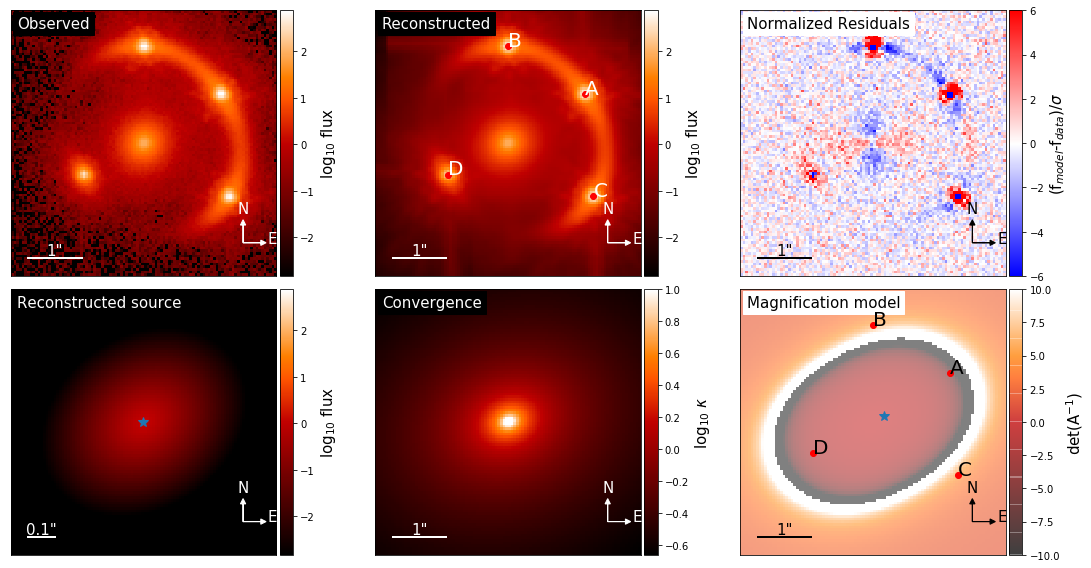

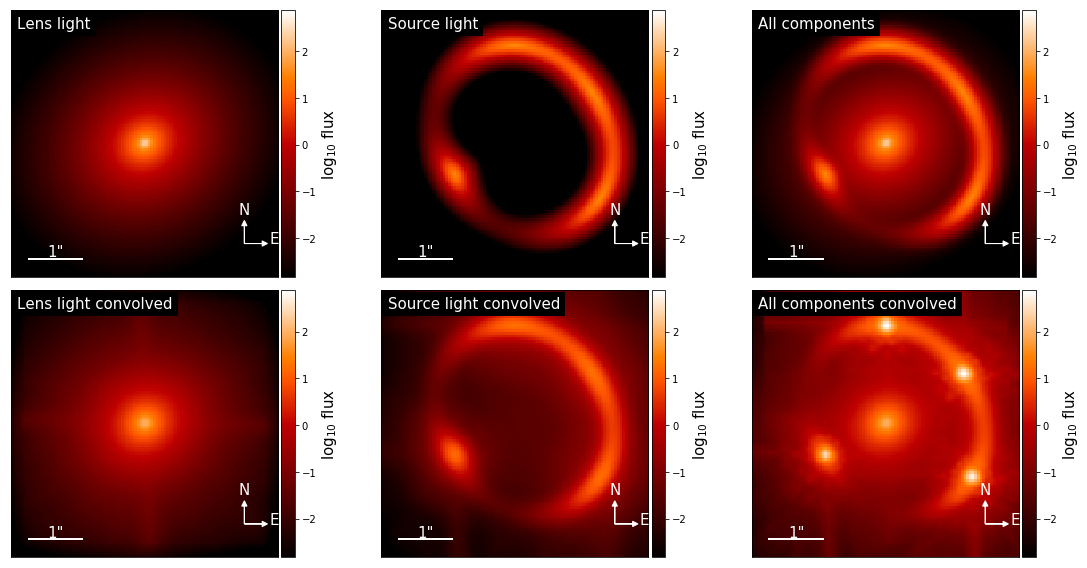

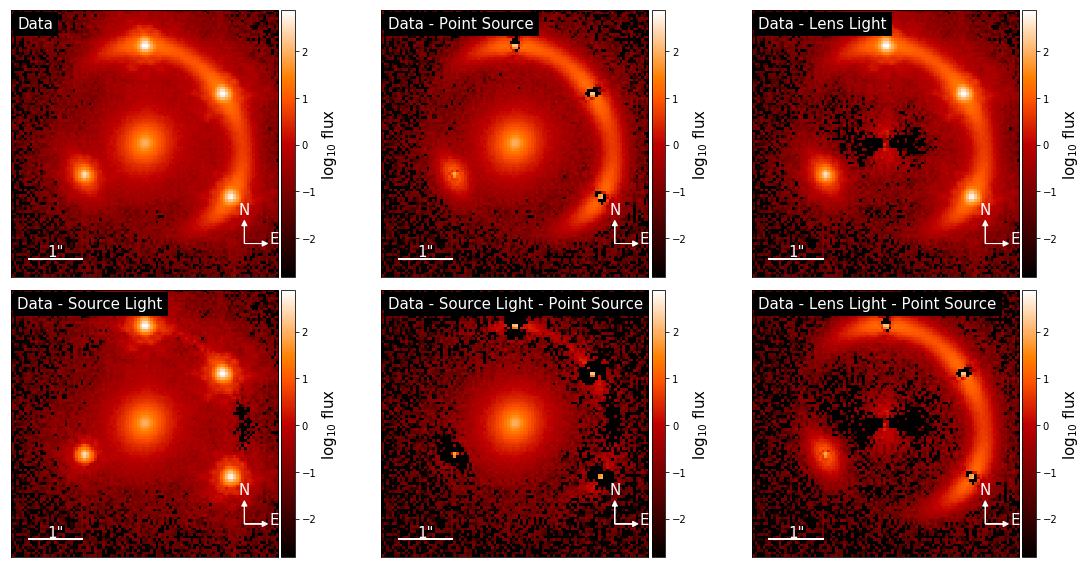

In [9]:
# now we first run a PSO with the wrong PSF
psf_iter_factor = 0.5
psf_iter_num = 100
sigma_scale = 0.1
# numerical options and fitting sequences

num_source_model = len(source_model_list)

kwargs_constraints = {'joint_source_with_point_source': [[0, 0]],
                              'num_point_source_list': [4],
                              'solver_type': 'PROFILE',  # 'PROFILE', 'PROFILE_SHEAR', 'ELLIPSE', 'CENTER'
                      'cosmo_type': 'D_dt'
                              }

kwargs_likelihood = {'check_bounds': True,
                             'force_no_add_image': False,
                             'source_marg': False,
                             'point_source_likelihood': False,
                             'position_uncertainty': 0.004,
                             'check_solver': True,
                             'solver_tolerance': 0.001,
                     
                             'time_delay_likelihood': True,
                             'time_delays_measured': dt_measured,
                             'time_delays_uncertainties': dt_sigma,
                             }

image_band = [kwargs_data, kwargs_psf, kwargs_numerics]
multi_band_list = [image_band]
kwargs_init = [kwargs_lens, kwargs_source, kwargs_lens_light, kwargs_ps]

from lenstronomy.Workflow.fitting_sequence import FittingSequence

mpi = False  # MPI possible, but not supported through that notebook.

from lenstronomy.Workflow.fitting_sequence import FittingSequence
fitting_seq = FittingSequence(multi_band_list, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params)
fitting_kwargs_list = [['update_settings', {'lens_add_fixed': [[0, ['gamma']]]}],
                       ['PSO', {'sigma_scale': sigma_scale, 'n_particles': 100, 'n_iterations': 100}],]

start_time = time.time()
chain_list, param_list, samples_mcmc, param_mcmc, dist_mcmc = fitting_seq.fit_sequence(fitting_kwargs_list)
lens_result, source_result, lens_light_result, ps_result, cosmo_result = fitting_seq.best_fit()
end_time = time.time()
print(end_time - start_time, 'total time needed for computation')
print('============ CONGRATULATION, YOUR JOB WAS SUCCESSFUL ================ ')

# here is the output

import lenstronomy.Plots.output_plots as out_plot
from lenstronomy.Plots.output_plots import LensModelPlot
lensPlot = LensModelPlot(kwargs_data, kwargs_psf, kwargs_numerics, kwargs_model, lens_result, source_result,
                             lens_light_result, ps_result, arrow_size=0.02, cmap_string="gist_heat")
f, axes = lensPlot.plot_main(); f.show()
f, axes = lensPlot.plot_separate(); f.show()
f, axes = lensPlot.plot_subtract_from_data_all(); f.show()

iteration of step 1 gave best reconstruction.
log likelihood before: -21252.266245541152 and log likelihood after: -7683.3602678386305


/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/Users/sibirrer/Software/lenstronomy/lenstronomy/Plots/output_plots.py:308: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(self._data), origin='lower',


reduced chi^2 =  1.609722665152466


/Users/sibirrer/Software/lenstronomy/lenstronomy/Plots/output_plots.py:615: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(self._data - model), origin='lower', vmin=v_min, vmax=v_max,


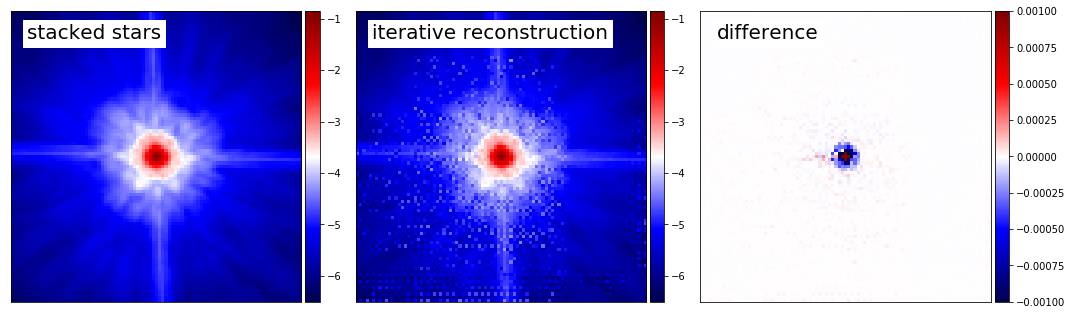

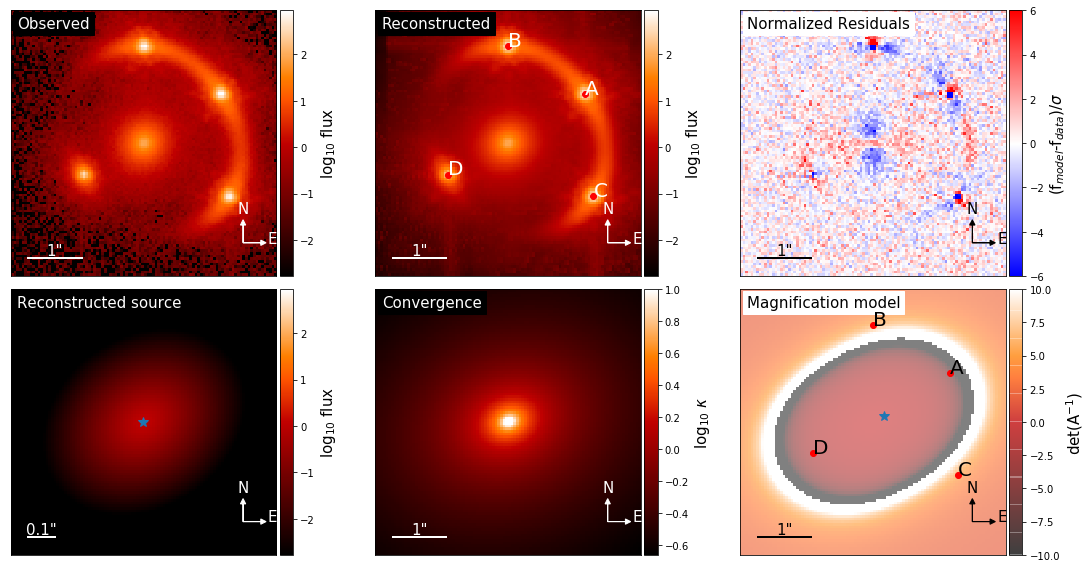

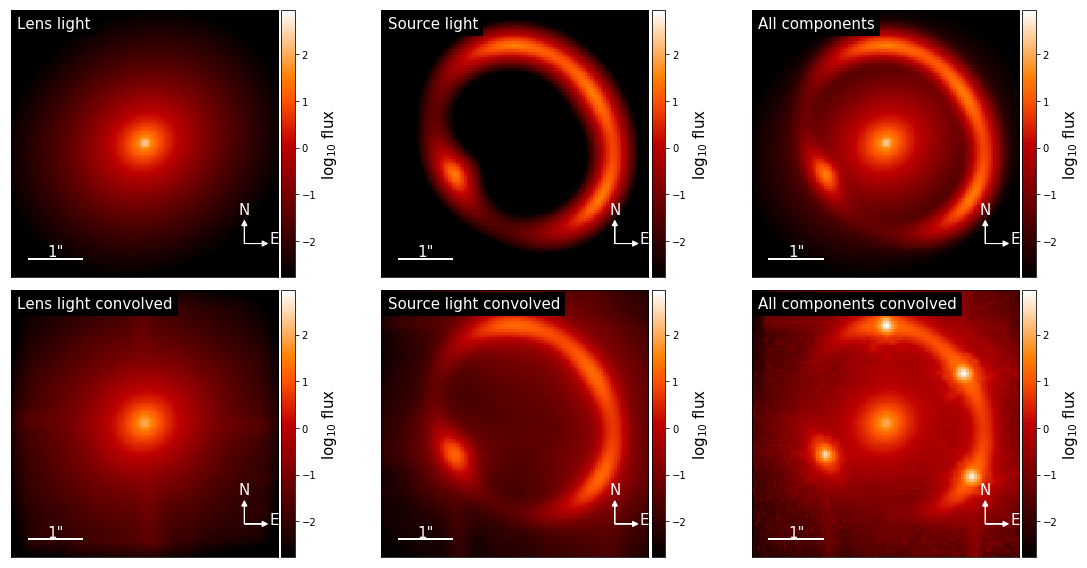

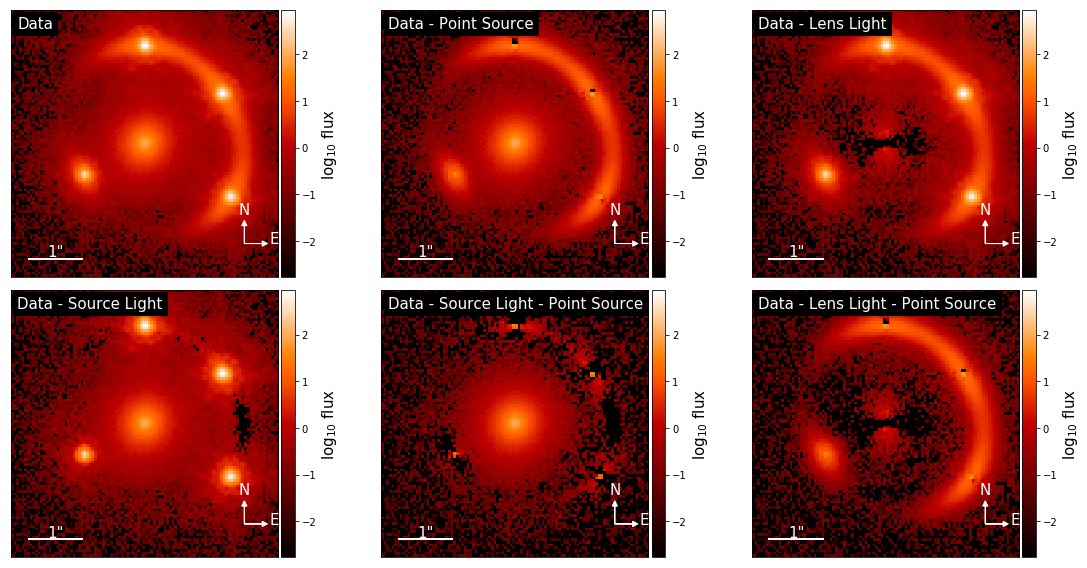

In [10]:
#now we run an iterative PSF reconstruction with the best fit model of the previous run
kwargs_psf_iter = {'stacking_method': 'median', 
                   'keep_psf_error_map': True, 
                   'psf_symmetry': 1, 
                   'block_center_neighbour': 0.05,
                   'num_iter': psf_iter_num, 
                   'psf_iter_factor': psf_iter_factor}
fitting_kwargs_list = [['psf_iteration', kwargs_psf_iter]]
chain_list, param_list, samples_mcmc, param_mcmc, dist_mcmc = fitting_seq.fit_sequence(fitting_kwargs_list)
#lens_result, source_result, lens_light_result, ps_result, cosmo_result

kwargs_data, kwargs_psf_updated, kwargs_numerics = fitting_seq.multi_band_list[0]
f, axes = out_plot.psf_iteration_compare(kwargs_psf_updated)
f.show()
lensPlot = LensModelPlot(kwargs_data, kwargs_psf_updated, kwargs_numerics, kwargs_model, lens_result, source_result,
                             lens_light_result, ps_result, arrow_size=0.02, cmap_string="gist_heat")
f, axes = lensPlot.plot_main()
f.show()
f, axes = lensPlot.plot_separate()
f.show()
f, axes = lensPlot.plot_subtract_from_data_all()
f.show()



/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/scipy-1.1.0-py3.6-macosx-10.13-x86_64.egg/scipy/optimize/minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
max iteration reached! stoping
-1.2893395406446353 reduced X^2 of best position
-6428.646949654151 logL
9972 effective number of data points
[{'theta_E': 1.6543055389366708, 'gamma': 2.0115814010299196, 'e1': 0.09237702030793365, 'e2': 0.08367829169130316, 'center_x': 0.013844289752636409, 'center_y': 0.007182241184416116}, {'e1': -0.008432459902913242, 'e2': -0.06449637138980938, 'ra_0': 0, 'dec_0': 0}] lens result
[{'amp': 1, 'R_sersic': 0.10576791041116437, 'n_sersic': 0.9019026564051509, 'e1': 0.06921794117241145, 'e2': 0.105080241684869, 'center_x': 0.21601546711061392, 'center_y': 0.1089299173200787}] source result
[{'amp': 1, 'R_sersic': 0.19572296003409956, 'n_sersic': 1.9914979903859689, 'e1': -0.011832936308899452, 'e2': 0.050317838943210375, 'center_x': -0.0002460947416481864, 'center_y': 0.00021341221684755975}] lens light result
[{'ra_image': array([ 1.45088915,  0.00430991,  1.60586856, -1.12459494]), 'dec_image': array

/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/Users/sibirrer/Software/lenstronomy/lenstronomy/Plots/output_plots.py:308: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(self._data), origin='lower',
/Users/sibirrer/Software/lenstronomy/lenstronomy/Plots/output_plots.py:615: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(self._data - model), origin='lower', vmin=v_min, vmax=v_max,


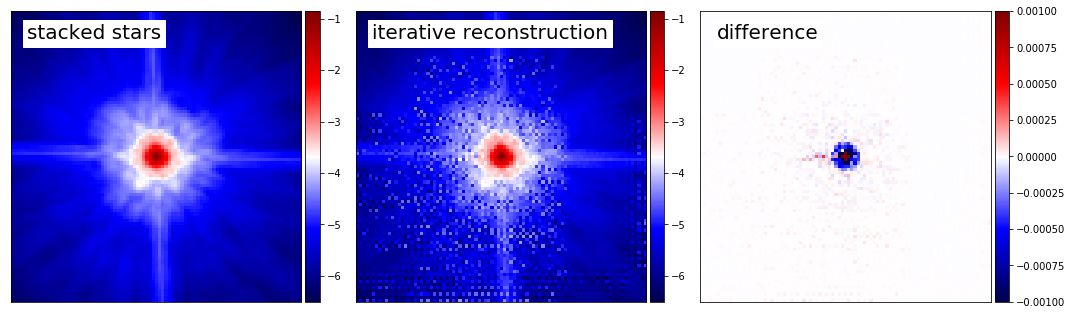

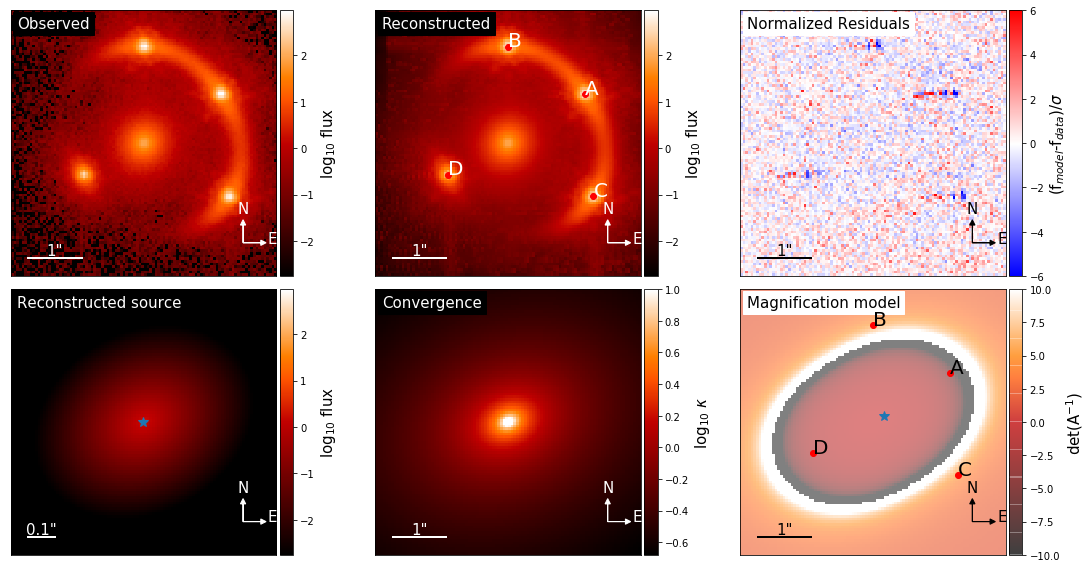

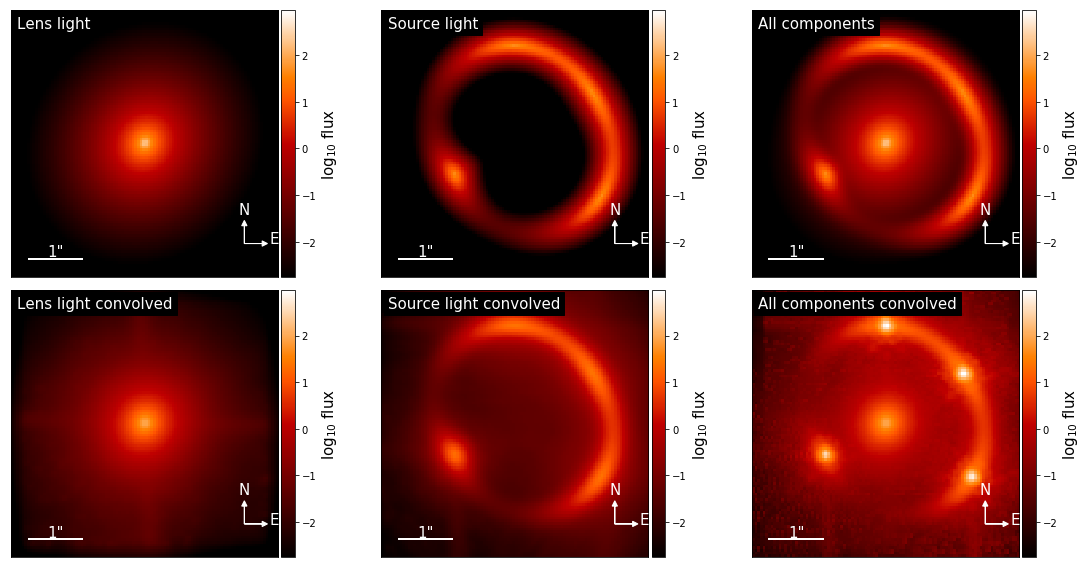

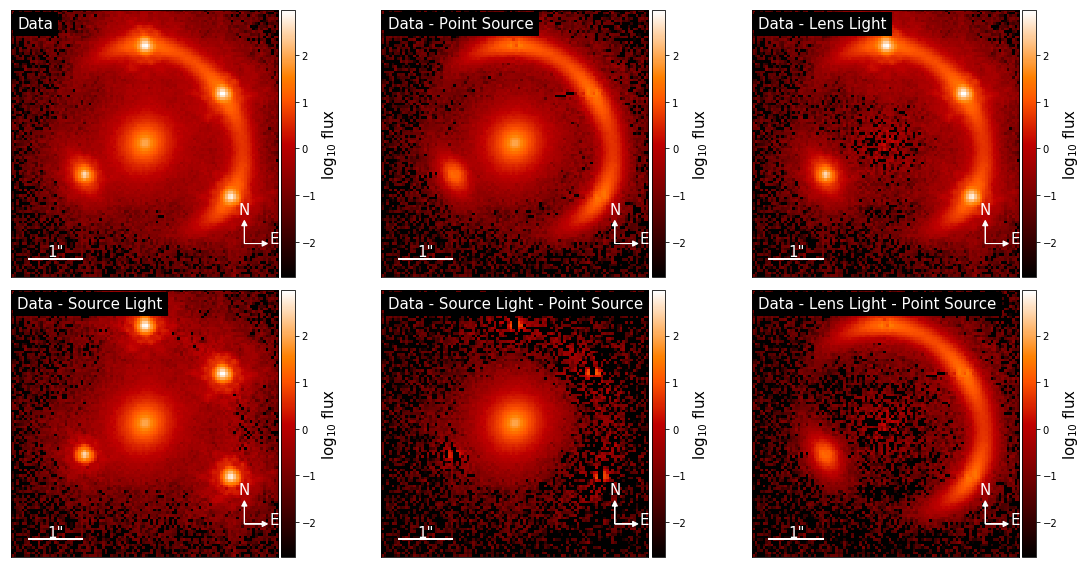

In [11]:
# and now we run another PSO optimization followed by another PSF iteration
fitting_kwargs_list = [['update_settings', {'lens_remove_fixed': [[0, ['gamma']]]}],
    ['PSO', {'sigma_scale': sigma_scale, 'n_particles': 100, 'n_iterations': 100}],
    ['psf_iteration', kwargs_psf_iter],
    ['PSO', {'sigma_scale': sigma_scale, 'n_particles': 100, 'n_iterations': 100}],
    ['psf_iteration', kwargs_psf_iter]]
chain_list, param_list, samples_mcmc, param_mcmc, dist_mcmc = fitting_seq.fit_sequence(fitting_kwargs_list)
lens_result, source_result, lens_light_result, ps_result, cosmo_result = fitting_seq.best_fit()

kwargs_data, kwargs_psf_updated, kwargs_numerics = fitting_seq.multi_band_list[0]
f, axes = out_plot.psf_iteration_compare(kwargs_psf_updated)
f.show()
lensPlot = LensModelPlot(kwargs_data, kwargs_psf_updated, kwargs_numerics, kwargs_model, lens_result, source_result,
                             lens_light_result, ps_result, arrow_size=0.02, cmap_string="gist_heat")
f, axes = lensPlot.plot_main()
f.show()
f, axes = lensPlot.plot_separate()
f.show()
f, axes = lensPlot.plot_subtract_from_data_all()
f.show()

/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/scipy-1.1.0-py3.6-macosx-10.13-x86_64.egg/scipy/optimize/minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
max iteration reached! stoping
-1.1535908056756707 reduced X^2 of best position
-5751.8037570988945 logL
9972 effective number of data points
[{'theta_E': 1.6569530520482014, 'gamma': 1.9889595406452243, 'e1': 0.09781232696995346, 'e2': 0.09490769187394738, 'center_x': 0.006364941894728848, 'center_y': 0.0032286554823011304}, {'e1': -0.004550028474275491, 'e2': -0.05746965210927307, 'ra_0': 0, 'dec_0': 0}] lens result
[{'amp': 1, 'R_sersic': 0.10178807907564143, 'n_sersic': 0.9621273563996993, 'e1': 0.06327422210398427, 'e2': 0.09979461112863919, 'center_x': 0.2101649578421261, 'center_y': 0.10540237329776553}] source result
[{'amp': 1, 'R_sersic': 0.1950108379306541, 'n_sersic': 1.908311480323602, 'e1': -0.013089440352347735, 'e2': 0.04939690147337757, 'center_x': -0.00029804737328575584, 'center_y': 4.8918642654928495e-06}] lens light result
[{'ra_image': array([ 1.45091947,  0.00407522,  1.60558154, -1.12379847]), 'dec_image': arr

/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/Users/sibirrer/Software/lenstronomy/lenstronomy/Plots/output_plots.py:308: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(self._data), origin='lower',
/Users/sibirrer/Software/lenstronomy/lenstronomy/Plots/output_plots.py:615: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(self._data - model), origin='lower', vmin=v_min, vmax=v_max,


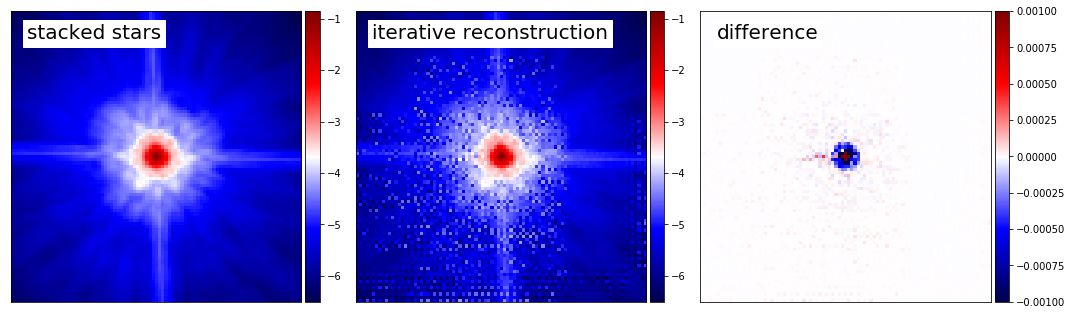

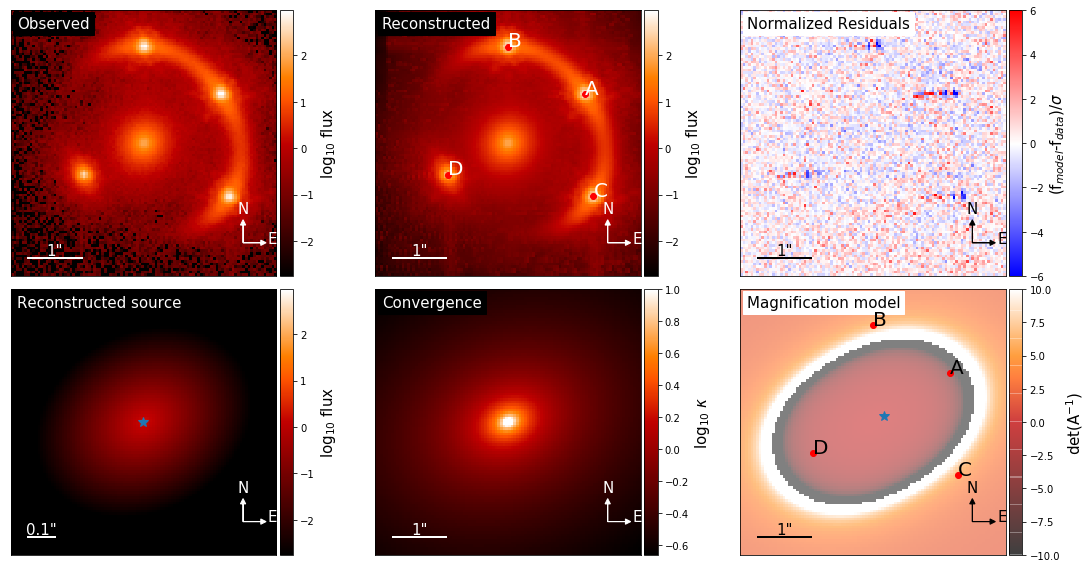

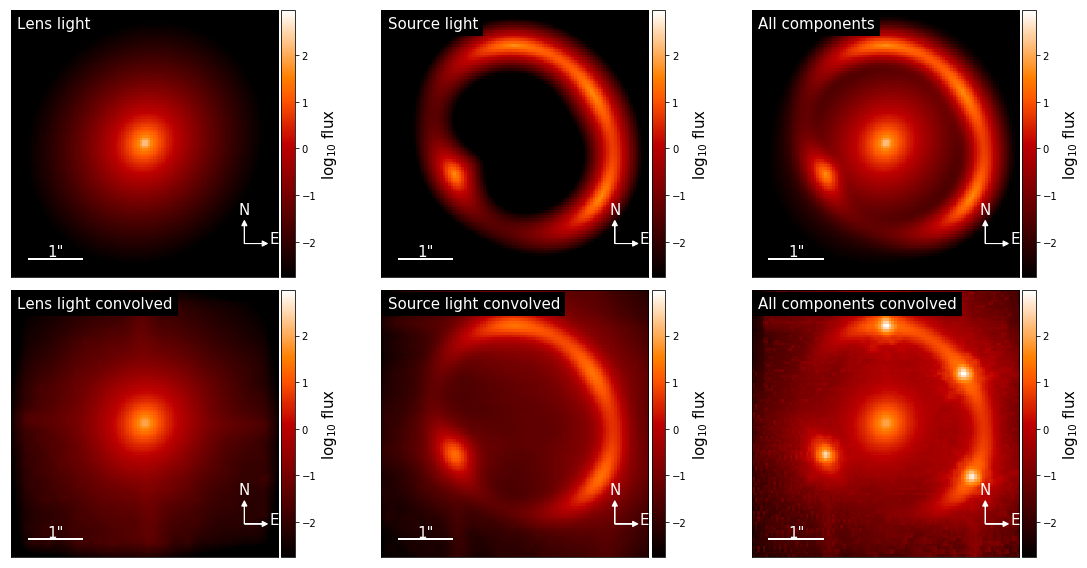

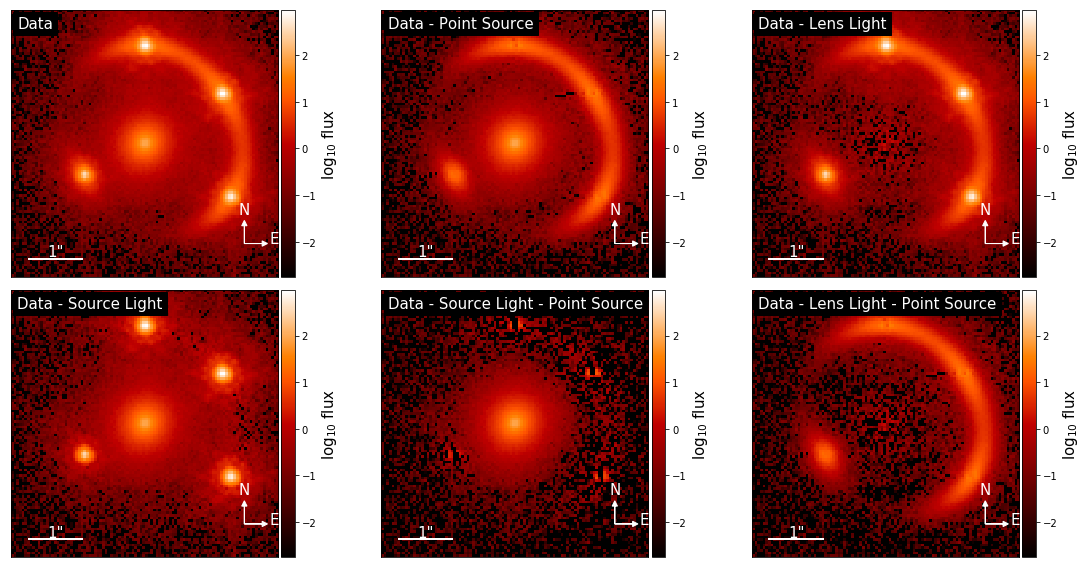

In [12]:
#and now we run the MCMC
fitting_kwargs_list = [
    ['PSO', {'sigma_scale': .1, 'n_particles': 100, 'n_iterations': 100}],
    ['MCMC', {'n_burn': 50, 'n_run': 50, 'walkerRatio': 10,'sigma_scale': .1}]
]
chain_list, param_list, samples_mcmc, param_mcmc, dist_mcmc = fitting_seq.fit_sequence(fitting_kwargs_list)
lens_result, source_result, lens_light_result, ps_result, cosmo_result = fitting_seq.best_fit()

kwargs_data, kwargs_psf_updated, kwargs_numerics = fitting_seq.multi_band_list[0]
f, axes = out_plot.psf_iteration_compare(kwargs_psf_updated)
f.show()
lensPlot = LensModelPlot(kwargs_data, kwargs_psf_updated, kwargs_numerics, kwargs_model, lens_result, source_result,
                             lens_light_result, ps_result, arrow_size=0.02, cmap_string="gist_heat")
f, axes = lensPlot.plot_main()
f.show()
f, axes = lensPlot.plot_separate()
f.show()
f, axes = lensPlot.plot_subtract_from_data_all()
f.show()

number of non-linear parameters in the MCMC process:  22
parameters in order:  ['gamma_lens', 'e1_lens', 'e2_lens', 'R_sersic_source_light', 'n_sersic_source_light', 'e1_source_light', 'e2_source_light', 'R_sersic_lens_light', 'n_sersic_lens_light', 'e1_lens_light', 'e2_lens_light', 'center_x_lens_light', 'center_y_lens_light', 'ra_image', 'ra_image', 'ra_image', 'ra_image', 'dec_image', 'dec_image', 'dec_image', 'dec_image', 'D_dt']
number of evaluations in the MCMC process:  11000


/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/scipy-1.1.0-py3.6-macosx-10.13-x86_64.egg/scipy/optimize/minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


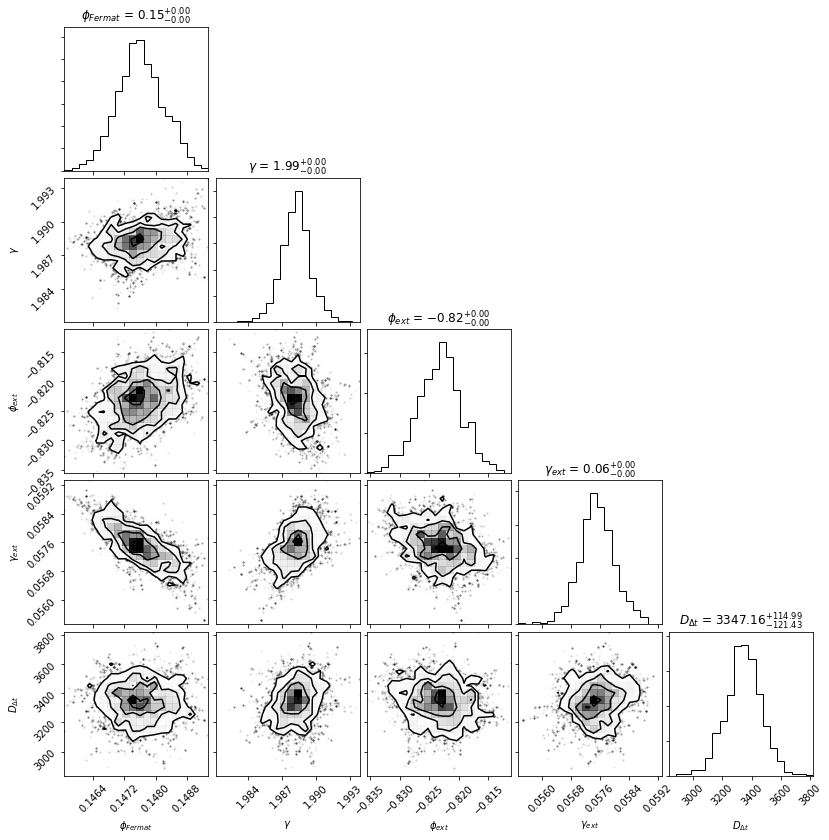

In [13]:
print("number of non-linear parameters in the MCMC process: ", len(param_mcmc))
print("parameters in order: ", param_mcmc)
print("number of evaluations in the MCMC process: ", np.shape(samples_mcmc)[0])
import corner


# import the parameter handling class #
from lenstronomy.Sampling.parameters import Param
# make instance of parameter class with given model options, constraints and fixed parameters #

param = Param(kwargs_model, fixed_lens, fixed_source, fixed_lens_light, fixed_ps, fixed_cosmo, 
              kwargs_lens_init=kwargs_lens, **kwargs_constraints)
# the number of non-linear parameters and their names #
num_param, param_list = param.num_param()

from lenstronomy.Analysis.lens_analysis import LensAnalysis
lensAnalysis = LensAnalysis(kwargs_model)

mcmc_new_list = []
labels_new = [r"$\phi_{Fermat}$", r"$\gamma$", r"$\phi_{ext}$", r"$\gamma_{ext}$", r"$D_{\Delta t}$"]
for i in range(len(samples_mcmc)):
    # transform the parameter position of the MCMC chain in a lenstronomy convention with keyword arguments #
    kwargs_lens_out, kwargs_light_source_out, kwargs_light_lens_out, kwargs_ps_out, kwargs_cosmo = param.args2kwargs(samples_mcmc[i])
    D_dt = kwargs_cosmo['D_dt']
    fermat_pot = lensAnalysis.fermat_potential(kwargs_lens_out, kwargs_ps_out)
    delta_fermat_12 = fermat_pot[0] - fermat_pot[2]
    gamma = kwargs_lens_out[0]['gamma']
    phi_ext, gamma_ext = lensAnalysis._lensModelExtensions.external_shear(kwargs_lens_out)
    mcmc_new_list.append([delta_fermat_12, gamma, phi_ext, gamma_ext, D_dt])


plot = corner.corner(mcmc_new_list, labels=labels_new, show_titles=True)

In [14]:
from lenstronomy.Cosmo.lens_cosmo import LensCosmo
lensCosmo = LensCosmo(z_lens=z_lens, z_source=z_source)
print(lensCosmo.D_dt)

3439.633754698765
